# Laboratorio 1.4
## Scegliere un verbo transitivo con almeno 2 argomenti, recuperare un corpus di $n$ istanze ($>1000$) in cui esso viene usato. 

- Effetuare parsing
- Effettuare disambiguazione usare i super sense di wordnet sugli argomenti del verbo scelto
- Aggregare i risultati
- Calcolare le frequenze
- Stampare i cluster semantici ottenuti.



In [2]:
from nltk.corpus import wordnet as wn, brown
import spacy #pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz # CONTROLLA VERSIONE CHE SERVE LA 3.0/3.1.0!
from nltk.stem import SnowballStemmer
import matplotlib.pylab as plt
import pandas as pd

## Estrazione del corpus

In [3]:
# Restituisce un corpus di frasi che contengono delle parole target
def extract_corpus(list_of_targets):
    corpus = []
    for sentence in brown.sents(): 
        for element in list_of_targets:
            if element in sentence:
                corpus.append(sentence)
                
    return corpus

## Disambiguazione
### Algoritmo di Lesk
Prende in input una parola e una frase e calcola il semantic type/ il supersense di quella parola.
- Si prenderanno tutti i possibili synset di quella parola, per esempio, `bank` in inglese può assumere significato di "istituto bancario" oppure di "banca del fiume (i.e. "riva"), allora attraverso l'algoritmo di lesk si otterrà l'informazione del fatto che `word='bank` sia stata utilizzata nel primo senso o nell'altro all'interno della `sentence='I went to the bank to deposit my money'`.
- Per ogni synset si creerà un set con la definizione di ogni synset (per esempio: `synset('Istituto_Bancario')`:`Luogo dove si fanno investimenti`).
    - Per ognuno di queste definizioni racimolerà degli esempi e li aggiungerà alla variabile `synset_definition`.

Da lì chi avrà il maggior numero di parole in comune tra il la frase di partenza tokenizzata `context` e la definizione sarà il synset vincitore che uscirà in output.

In [4]:
def lesk(word, sentence):
    sense = ''
    max_overlap = -1
    context = set(sentence.split()) # Tokenizzazione della frase che si sta valutando

    # Si cicla su ogni possibile synset della parola
    for synset in wn.synsets(word):

        # Si trasforma in un set di token ogni definizione di ogni synset
        synset_definition = set(synset.definition().split()) 
        #print(f"{synset} \n Definizione del synset: {synset_definition}\n" )

        # Si cicla su ogni esempio disponibile per il synset
        for example in synset.examples():

            # Si aggiorna la definizione aggiungendone gli esempi
            synset_definition.update(example.split())
            #print(f"{synset} \n Definizione: {synset_definition} \n Esempio: {example}\n")

        # Con le definizioni arricchite dagli esempi si valuta quante parole si incrociano con il contesto
        overlap = len(context & synset_definition)
        print(f"Overlap: {overlap} \n Contesto: \t - {context} \n Definizione: \t - {synset_definition} \n")

        # La definizione con più overlapping sarà l'output
        if overlap > max_overlap:
            sense = synset
            max_overlap = overlap

    return sense

## Parsing ed esecuzione della disambiguazione sui supersensi trovati

In [5]:
def extract_supersenses(corpus, verbs):

    # Parsing in sintassi a dipendenze
    parser = spacy.load("en_core_web_sm") # pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
    
    args = []
    items = []
    for sentence in corpus:
        arg_subject = ''
        arg_object = ''
        root = False
        sentence = ' '.join(sentence)

        # Note su SpaCy:
        # token.dep_ spiega il ruolo del token nella frase \ E' differente da token.dep che restituisce un intero
        # token.head.text specifica il governatore, la head dell'albero sintattico del parser
        
        for token in parser(sentence):

            if token.head.text in verbs:

                # Il ruolo del token nella frase è quello di soggetto
                if token.dep_ == 'nsubj':
                    arg_subject = token.text

                # Il ruolo del token nella frase è quello di oggetto
                elif token.dep_ == 'dobj':
                    arg_object = token.text

                # Il ruolo del token è la radice dell'albero sintattico
                elif token.dep_ == 'ROOT':
                    root = True
                    items.append(token.dep_)

                # Frasi passive: 'nmod' diventa soggetto
                elif token.dep_ == 'agent':
                    arg_subject = token.text
                    passive = True
                    print(f"Scusa Gesù - {sentence}")

                # Frasi passive: 'nsubjpass' diventa oggetto
                elif token.dep_ == "nsubjpass":
                    arg_object = token.text
                    passive = True
                    print(f"Dio porco - {sentence}")

        # COLLOCAZIONE: Si riempiono i vari "filler" con i vari soggetti e oggetti possibili per il verbo scelto
        
        # Tramite questo "if" si valuta se il verbo scelto ha almeno 2 argomenti
        if root and arg_subject and arg_object:

            if lesk(arg_subject, sentence):
                arg_subject = lesk(arg_subject, sentence).lexname()
            else:
                arg_subject = 'noun.person' # Se non ha funzionato l'algoritmo di lesk si assume che sia un nome di persona
            
            if lesk(arg_object, sentence):
                arg_object = lesk(arg_object, sentence).lexname()
            else:
                arg_object = 'noun.person' # Se non ha funzionato l'algoritmo di lesk si assume che sia un nome di persona

            args.append((arg_subject, arg_object))
            
    return args, len(items)

## Generazione delle frequenze

In [6]:
def generate_frequencies(list_of_datas):
    frequencies = {}
    for tpl in args:
        frequencies.setdefault(str(tpl)[1:-1], args.count(tpl))
    return frequencies


## Data Visualization

In [7]:
# Stampa gli istogrammi delle frequenze dei semantic types
def plot_frequencies(dictionary, verb):
    keys = [arg.replace("'", "").replace(",", " -") for arg in list(dictionary.keys())]
    plt.bar((keys), list(dictionary.values()), color="#C90000")
    plt.xticks(rotation=60, ha='right', fontsize=8)
    plt.grid(axis='y', alpha=.5)
    plt.title(f'Occorrenze di semantic types del verbo "to {verb}"', color="#C90000")

    plt.show()

In [8]:
# Stampa un riepilogo testuale delle frequenze dei semantic types e altri elementi
def print_output(dictionary, verb, corpus_length, args):
    print(f"Sono state rilevate {len(list(dictionary.keys()))} coppie di semantic types per il verbo 'to {verb}' su un corpus avente {corpus_length} frasi. \nA seguire il report esteso:\n")
    
    total = sum(list(dictionary.values()))
    for key in dictionary.keys():
        arg = key.replace("'", "")
        arg = arg.replace(",", " -")
        print(f"\t{arg}: \t {dictionary[key]} / {total}")

In [9]:
# Esegue entrambe le funzioni di questa categoria
def print_and_plot_output(dictionary, verb, corpus_length, args):
    print_output(dictionary, verb, corpus_length, args)
    plot_frequencies(dictionary, verb)
    

## Esecuzione del codice

In [10]:
# Lista di parole da utilizzarsi per estrarre frasi dal corpus
verbs = ['say', 'says', 'said', 'saying']

# Corpus avente frasi con le parole nella lista targets
corpus = extract_corpus(verbs)

# Estrazione dei supersensi
args, items_length = extract_supersenses(corpus, verbs)

Dio porco - I hope it can be said without boasting that no other nation offers its vacationing motorists such variety and beauty of scene , such an excellent network of roads on which to enjoy it and such decent , far-flung over-night accommodations .
Dio porco - His condition was said to be , `` fair '' .
Dio porco - More than 1,000 were said to have been arrested -- 100 of them Roman Catholic priests .
Overlap: 0 
 Contesto: 	 - {'.', 'said', 'Klux', 'juror', 'when', 'complaint', 'the', 'false', 'that', 'gave', 'U.S.', 'Klan', 'during', 'Attorney', 'Ku', 'membership', 'Weaver', 'information', 'of', 'asked', 'jury', 'Macon', 'federal', 'about', ',', 'charged', 'selection'} 
 Definizione: 	 - {'weaves', 'cloth', 'craftsman', 'who', 'a'} 

Overlap: 0 
 Contesto: 	 - {'.', 'said', 'Klux', 'juror', 'when', 'complaint', 'the', 'false', 'that', 'gave', 'U.S.', 'Klan', 'during', 'Attorney', 'Ku', 'membership', 'Weaver', 'information', 'of', 'asked', 'jury', 'Macon', 'federal', 'about', ',', 

Sono state rilevate 32 coppie di semantic types per il verbo 'to say' su un corpus avente 1772 frasi. 
A seguire il report esteso:

	noun.person - noun.communication: 	 7 / 86
	noun.artifact - noun.time: 	 1 / 86
	noun.person - noun.person: 	 18 / 86
	noun.person - noun.artifact: 	 1 / 86
	noun.substance - noun.communication: 	 3 / 86
	noun.substance - adj.pert: 	 1 / 86
	adv.all - noun.communication: 	 1 / 86
	noun.person - noun.cognition: 	 5 / 86
	noun.person - adj.all: 	 3 / 86
	noun.substance - noun.quantity: 	 4 / 86
	noun.substance - noun.group: 	 1 / 86
	noun.person - noun.quantity: 	 7 / 86
	noun.plant - adv.all: 	 1 / 86
	noun.communication - noun.time: 	 1 / 86
	noun.substance - noun.person: 	 6 / 86
	noun.person - noun.event: 	 1 / 86
	noun.quantity - noun.person: 	 6 / 86
	noun.substance - noun.event: 	 2 / 86
	noun.substance - adv.all: 	 1 / 86
	noun.cognition - noun.group: 	 1 / 86
	noun.cognition - noun.artifact: 	 1 / 86
	noun.state - noun.person: 	 1 / 86
	noun.person

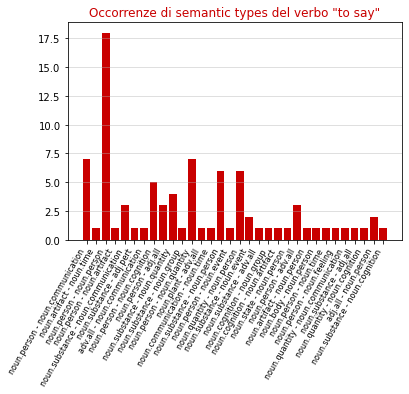

In [11]:
# Generazione di una lista di set con le frequenze
frequencies = generate_frequencies(args)

# Stampa l'output
print_and_plot_output(frequencies, verbs[0], items_length, args)

## Implementazione con un dataset diverso

```def extract_data2():
    df = pd.read_csv('dataset/play.csv', header=0, sep=",")
    #df.drop(['corpus'],axis=1,inplace=True)
    data = df.values.tolist()
    return data
print(len(extract_data2()))```

```def preprocess_data(corpus):
    output = []
    for propositions in corpus:
        sentence = str(propositions[0]) + " " + str(propositions[1]) + " " +  str(propositions[2])
        if sentence.find('<s>'):
            sentence = sentence.replace('<s>', '')
        elif sentence.find('</s>'):
            sentence = sentence.replace('</s>', '')
        output.append(sentence)
    return output```

```verbs2 = ['play', 'played', 'playing']

corpus2 = extract_data2()
corpus2 = preprocess_data(corpus2)

# Estrazione dei supersensi
args2 = extract_supersenses(corpus2, verbs2)

# Generazione di una lista di set con le frequenze
frequencies2 = generate_frequencies(args2)````

```plot_frequencies(frequencies2)```